In [ ]:
# --- Импорт необходимых библиотек ---
import json          # Для чтения JSON Lines файлов
from pathlib import Path  # Для удобной работы с путями
import random        # Для случайного перемешивания данных
import numpy as np   # Для числовых операций, особенно для метрики WAPE
import torch         # PyTorch для работы с тензорами
import matplotlib.pyplot as plt  # Для построения графиков
from tqdm.auto import tqdm    # Для прогресс-баров
from chronos import ChronosPipeline  # Основной класс из библиотеки Chronos для инференса (прогнозирования)
import warnings      # Для управления предупреждениями

# Отключаем некритичные предупреждения для чистоты вывода
warnings.filterwarnings("ignore", category=UserWarning, module="torch")
warnings.filterwarnings("ignore", category=FutureWarning)


# --- 1. КОНФИГУРАЦИЯ ---
# Блок с основными параметрами для легкой настройки.

# Путь к папке с вашей дообученной моделью.
# 'checkpoint-final' - это папка, которую создает Trainer после завершения обучения.
MODEL_CHECKPOINT_PATH = "./output_102/checkpoint-final"

# Папка, из которой мы будем читать подготовленные для теста данные.
TEST_DATA_DIR = Path("chronos_univariate_dataset")

# ВАЖНО: Горизонт прогнозирования.
# Это значение должно быть АБСОЛЮТНО ИДЕНТИЧНО тому `prediction_length`,
# с которым вы обучали модель и готовили тестовые данные.
PREDICTION_LENGTH = 8

# Количество случайных примеров для визуализации в конце.
NUM_SAMPLES_TO_VISUALIZE = 5


# --- 2. УЛУЧШЕННАЯ И НАДЕЖНАЯ ФУНКЦИЯ WAPE ---
# WAPE (Weighted Absolute Percentage Error) - это ключевая метрика для оценки точности прогнозов спроса.
def calculate_wape(actual, forecast):
    """
    Рассчитывает WAPE. Формула: 100 * Сумма(|Факт - Прогноз|) / Сумма(|Факт|)
    """
    # Преобразуем входные данные в numpy-массивы для надежных вычислений.
    actual = np.asarray(actual)
    forecast = np.asarray(forecast)
    
    # Считаем знаменатель - сумму реальных продаж.
    sum_actual = np.sum(np.abs(actual))
    
    # --- ОБРАБОТКА КРАЙНЕГО СЛУЧАЯ ---
    # ПОЧЕМУ ЭТО ВАЖНО: Если реальные продажи за весь период были равны нулю,
    # знаменатель будет 0, что вызовет ошибку деления на ноль.
    if sum_actual == 0:
        # Если и факт, и прогноз равны нулю, ошибка равна 0% (идеальный прогноз).
        if np.sum(np.abs(actual - forecast)) == 0:
            return 0.0
        # Если факт=0, а прогноз > 0, метрика не определена. Возвращаем NaN (Not a Number).
        else:
            return np.nan
            
    # Если знаменатель не равен нулю, считаем WAPE по стандартной формуле.
    return 100 * np.sum(np.abs(actual - forecast)) / sum_actual


# --- ОСНОВНОЙ КОД ---
# Эта конструкция гарантирует, что код выполнится только при прямом запуске скрипта.
if __name__ == "__main__":
    print(f"--- Шаг 1: Загрузка дообученной модели из '{MODEL_CHECKPOINT_PATH}' ---")

    # Создаем объект ChronosPipeline. Это высокоуровневый интерфейс, который "под капотом"
    # загружает и модель, и токенизатор, и всю необходимую конфигурацию из указанной папки.
    pipeline = ChronosPipeline.from_pretrained(
        MODEL_CHECKPOINT_PATH,
        # Автоматически выбираем GPU, если он доступен, иначе CPU.
        device_map="cuda" if torch.cuda.is_available() else "cpu",
        # Используем bfloat16 для ускорения на современных GPU, если возможно.
        dtype=torch.bfloat16 if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else torch.float32,
    )

    print("\n--- Шаг 2: Загрузка тестовых данных ---")
    # Определяем пути к двум файлам, созданным на предыдущем шаге.
    test_context_path = TEST_DATA_DIR / "test_context.jsonl" # Содержит историю (для подачи в модель).
    test_actuals_path = TEST_DATA_DIR / "test_actuals.jsonl" # Содержит полные ряды (для проверки).

    # Загружаем историю (контекст) в список словарей.
    contexts = []
    with open(test_context_path, "r") as f:
        for line in f:
            contexts.append(json.loads(line))
            
    # Загружаем полные данные в словарь (map) для быстрого доступа по item_id.
    # Это гораздо эффективнее, чем искать в DataFrame в цикле.
    actuals_map = {}
    with open(test_actuals_path, "r") as f:
        for line in f:
            data = json.loads(line)
            actuals_map[data["item_id"]] = data["target"]

    print(f"Загружено {len(contexts)} временных рядов для тестирования.")

    print("\n--- Шаг 3: Генерация прогнозов и расчет метрик ---")
    # Список для хранения WAPE для каждого отдельного ряда.
    all_wape_scores = []
    
    # Перемешиваем контексты, чтобы на этапе визуализации видеть случайные,
    # а не первые попавшиеся ряды.
    random.shuffle(contexts)
    # Для ускорения процесса мы можем взять не все данные, а только их часть (подвыборку).
    # Для финального расчета закомментируйте эту строку, чтобы использовать все данные.
    test_subset = contexts[:500] 

    # Итерируемся по каждому ряду из нашей тестовой выборки с прогресс-баром.
    for series in tqdm(test_subset, desc="Прогнозирование"):
        item_id = series["item_id"]
        # Преобразуем историю в тензор PyTorch.
        context_data = torch.tensor(series["target"])
        
        # --- ГЕНЕРАЦИЯ ПРОГНОЗА ---
        # `pipeline.predict()` - основная функция для получения прогноза.
        # Она возвращает не один прогноз, а `num_samples` (20) вероятных траекторий будущего.
        forecast_samples = pipeline.predict(
            context=context_data,
            prediction_length=PREDICTION_LENGTH,
            num_samples=20, # Количество траекторий для большей стабильности
        )
        
        # `forecast_samples` имеет форму (1, 20, 8). Нам нужно агрегировать 20 траекторий.
        # Мы вычисляем медиану по оси сэмплов (dim=1). Это дает нам один, наиболее вероятный прогноз.
        # .squeeze() убирает лишние измерения, .cpu().numpy() перемещает тензор на CPU и конвертирует в numpy.
        median_forecast = torch.quantile(forecast_samples, 0.5, dim=1).squeeze().cpu().numpy()

        # --- СРАВНЕНИЕ С ФАКТОМ ---
        # Находим полный временной ряд по его ID в нашем словаре.
        full_actual_series = actuals_map[item_id]
        # Отрезаем "хвост" - реальное будущее, с которым будем сравнивать.
        actual_future = full_actual_series[-PREDICTION_LENGTH:]
        
        # Рассчитываем WAPE для этого одного ряда.
        wape = calculate_wape(actual_future, median_forecast)
        all_wape_scores.append(wape)

    print(f"\n--- Шаг 4: Результаты оценки ---")
    # Считаем средний WAPE по всем рядам.
    # `np.nanmean` - это специальная версия `np.mean`, которая ИГНОРИРУЕТ значения NaN.
    # Это важно, так как наша функция calculate_wape возвращает NaN для рядов с нулевыми продажами.
    average_wape = np.nanmean(all_wape_scores) 
    print(f"Средний WAPE по {len(test_subset)} тестовым рядам: {average_wape:.2f}%")

--- Шаг 1: Загрузка дообученной модели из './output_univariate/checkpoint-final' ---

--- Шаг 2: Загрузка тестовых данных ---
Загружено 177780 временных рядов для тестирования.

--- Шаг 3: Генерация прогнозов и расчет метрик ---


Прогнозирование:   0%|          | 0/500 [00:00<?, ?it/s]


--- Шаг 4: Результаты оценки ---
Средний WAPE по 500 тестовым рядам: 118.52%



--- Шаг 5: Визуализация случайных примеров ---


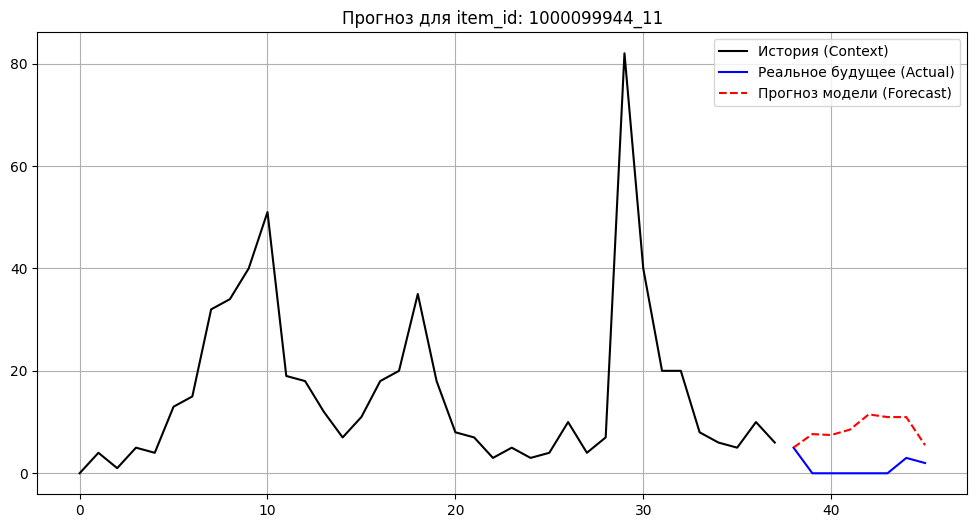

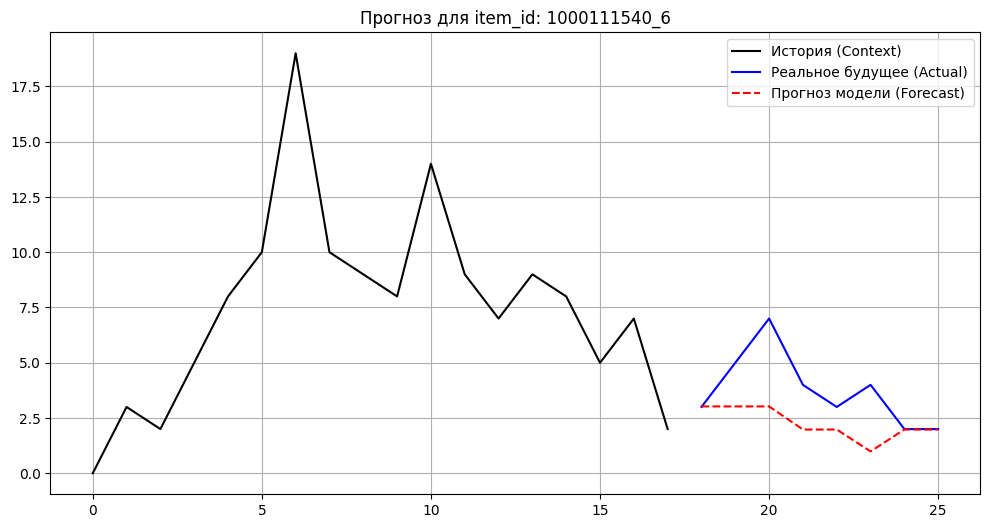

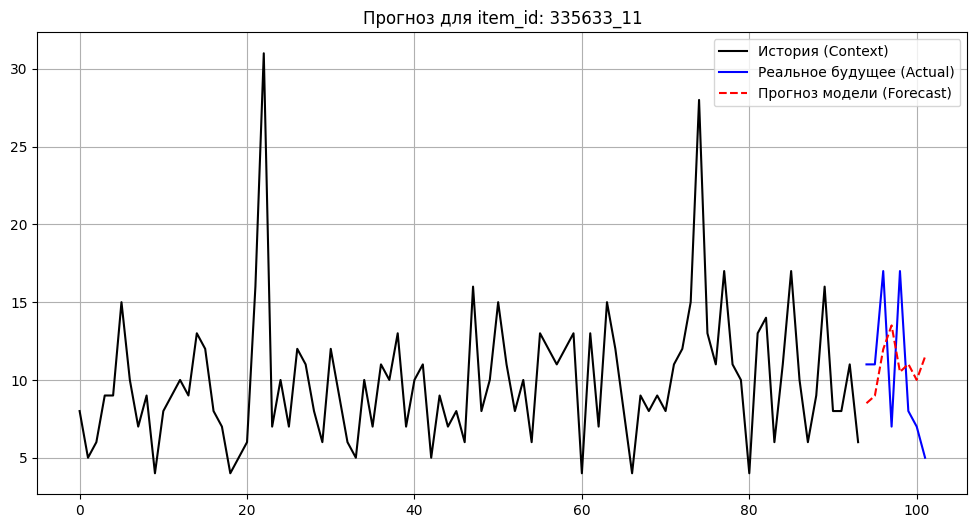

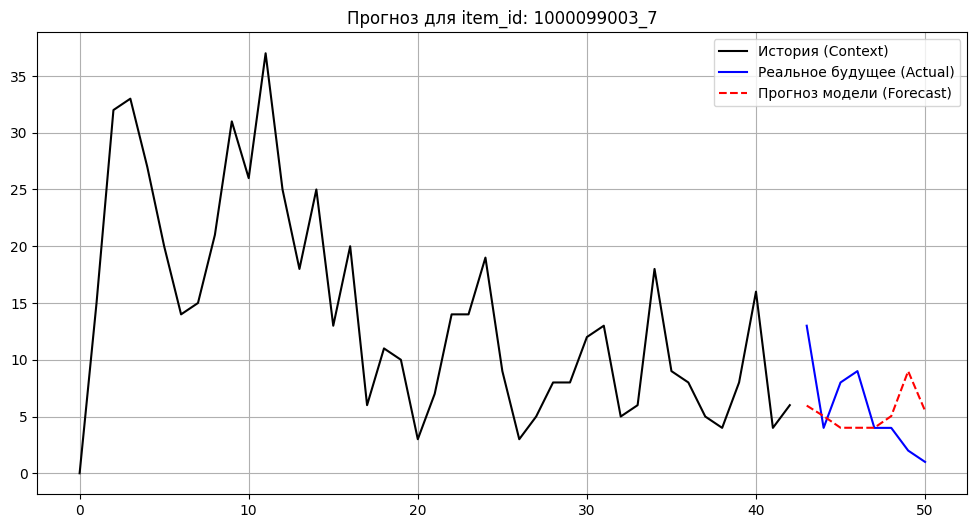

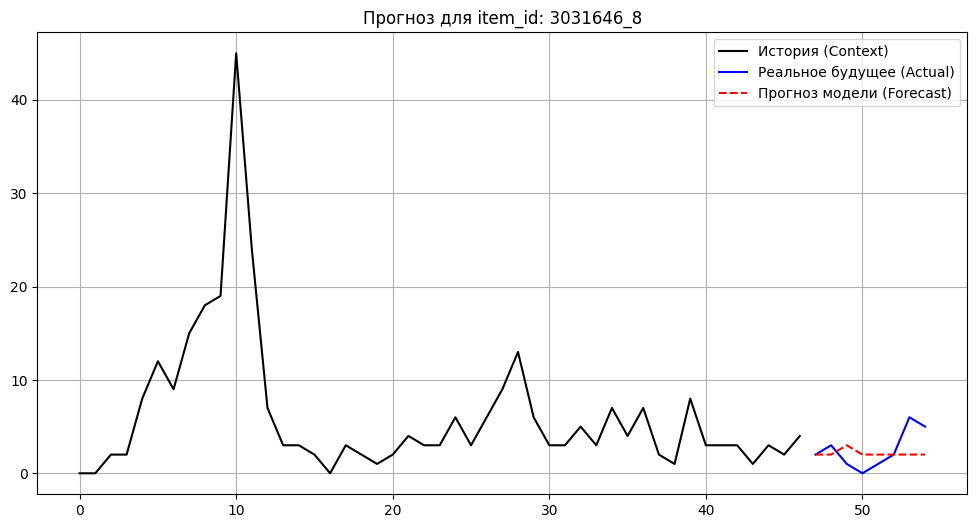

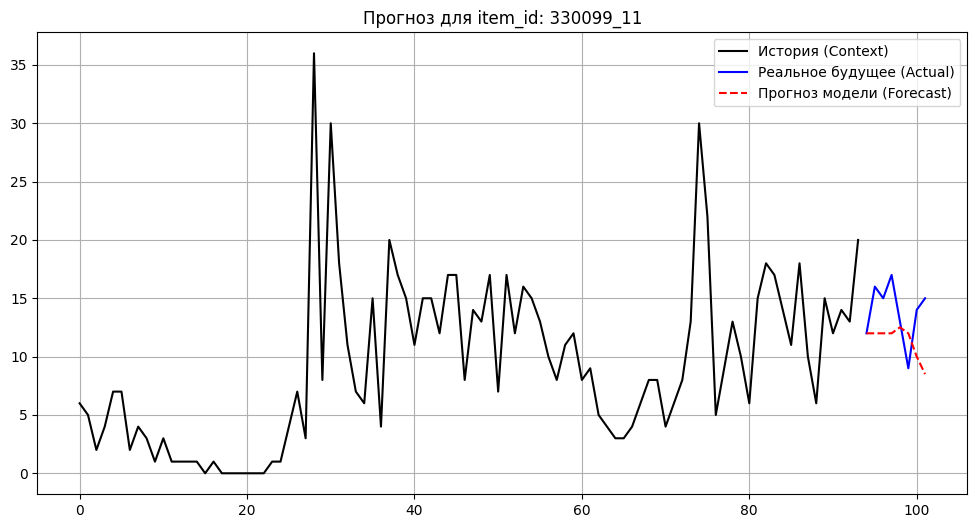

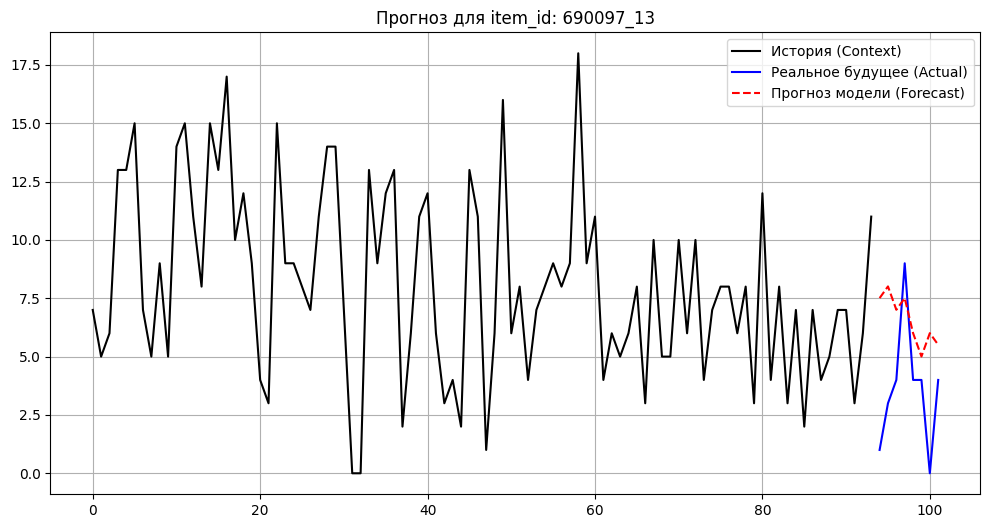

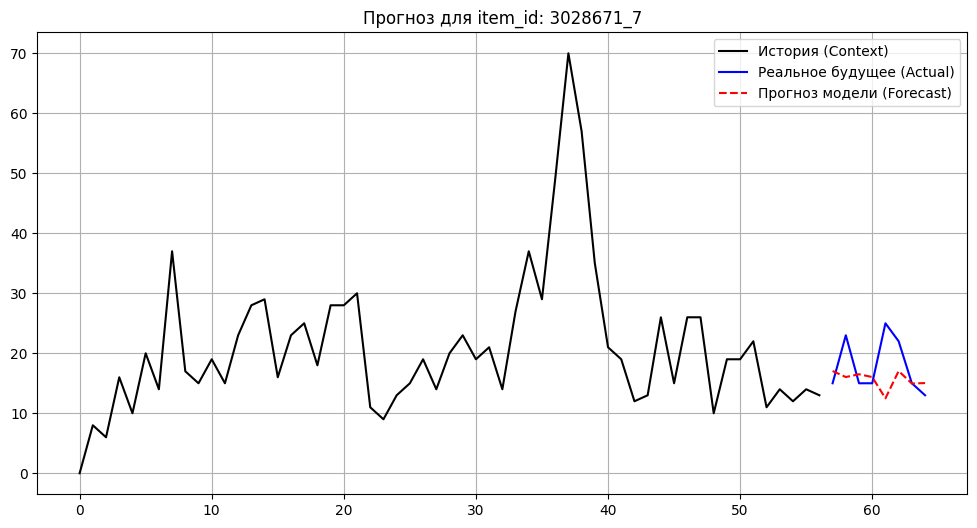

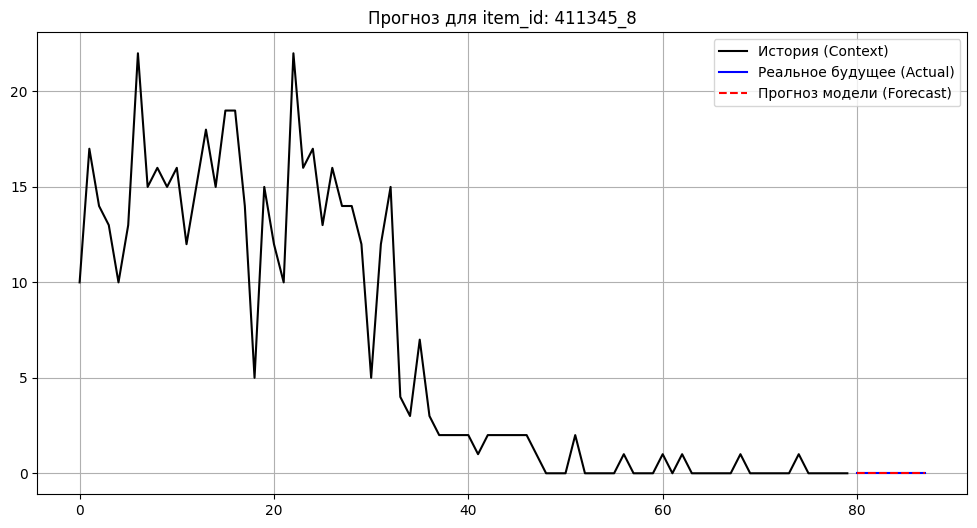

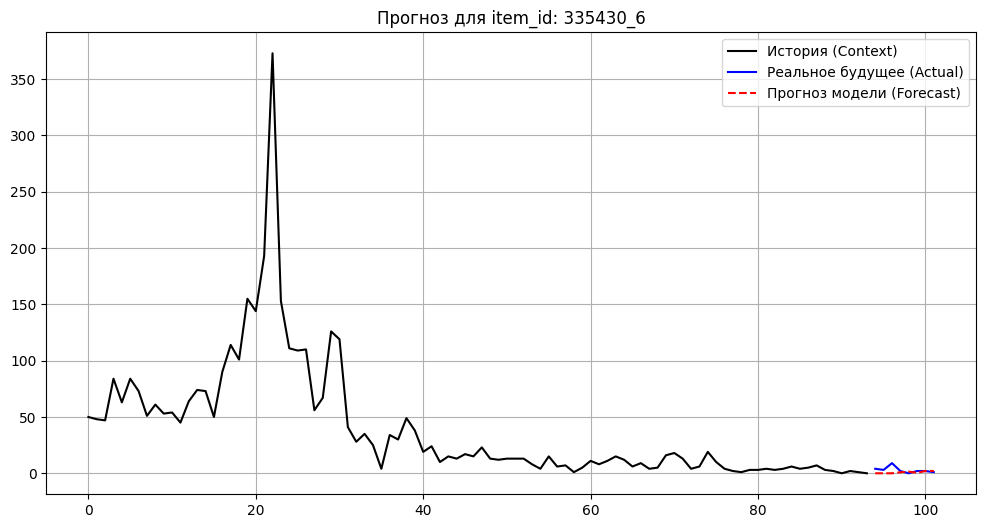

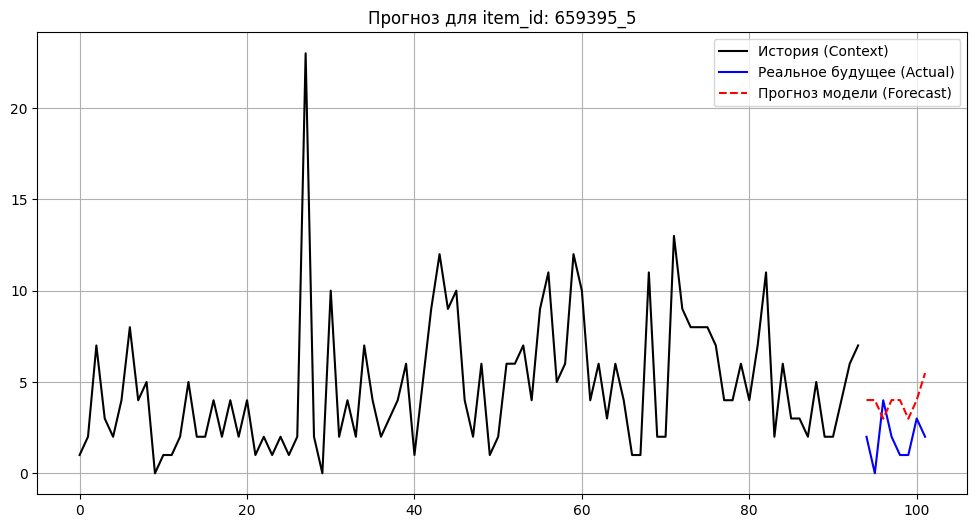

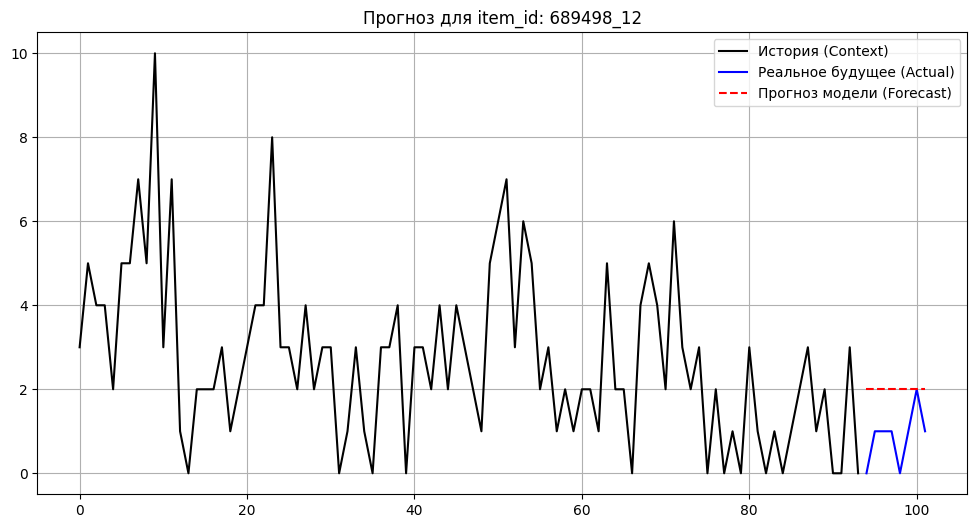

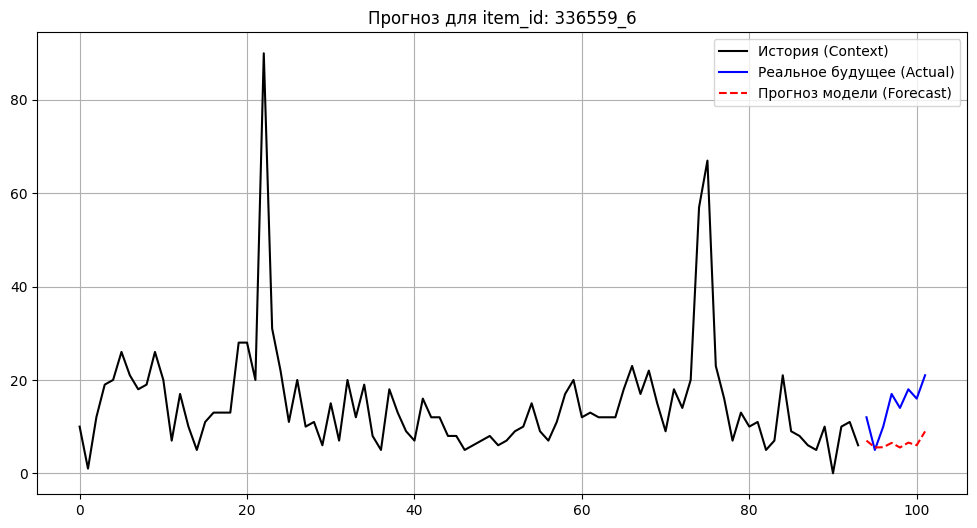

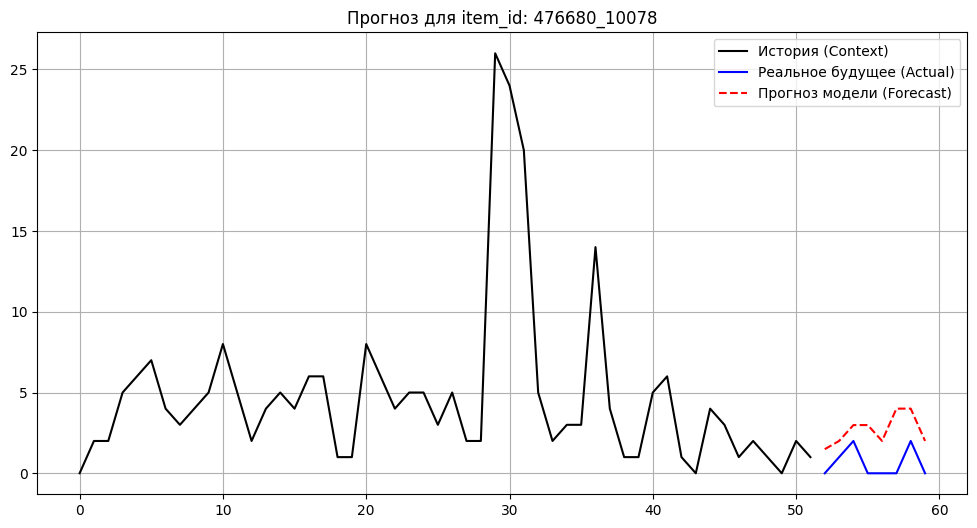

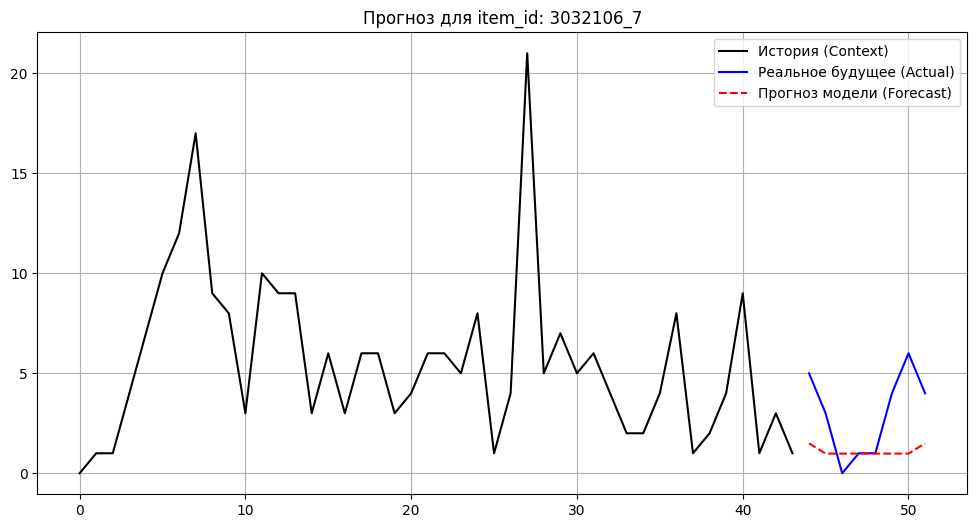

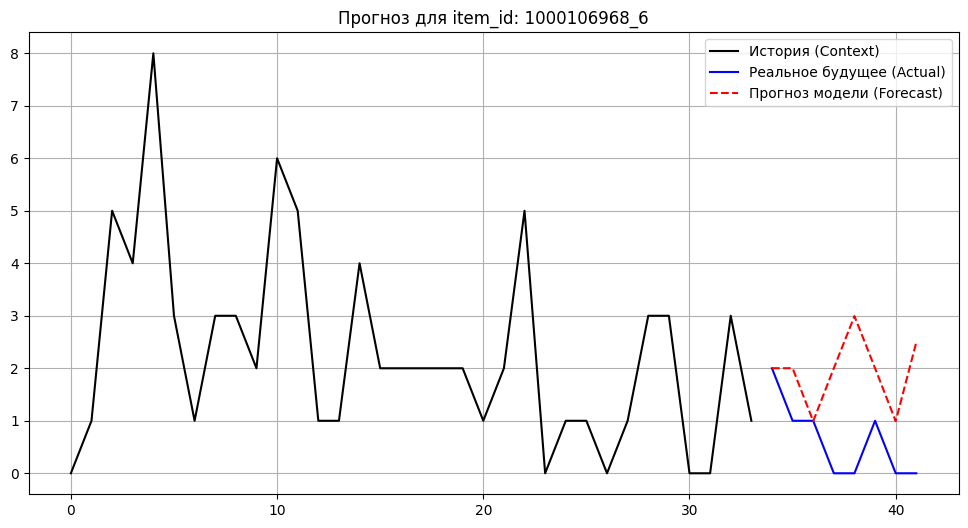

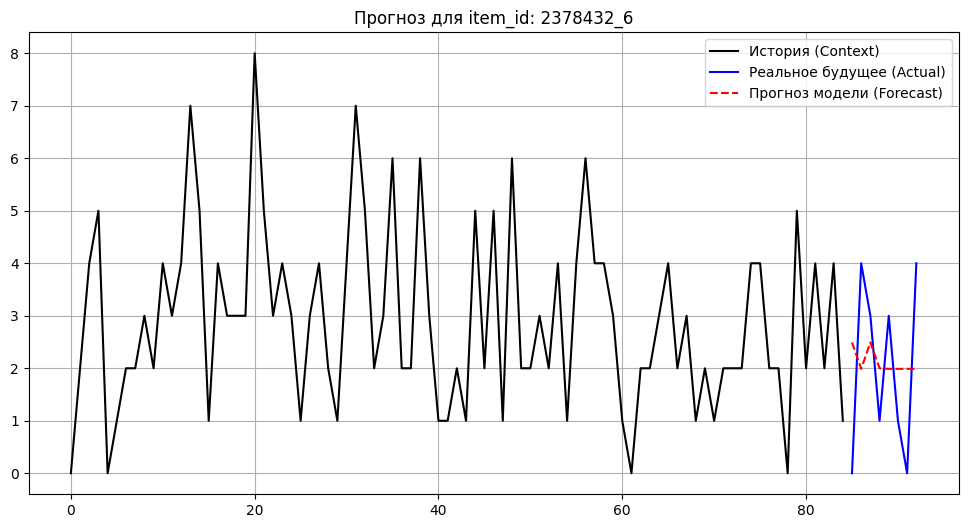

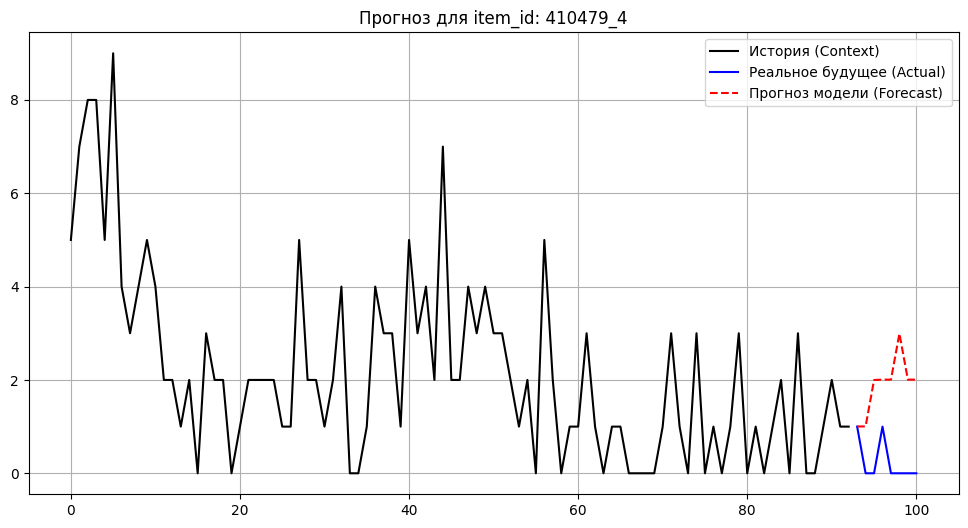

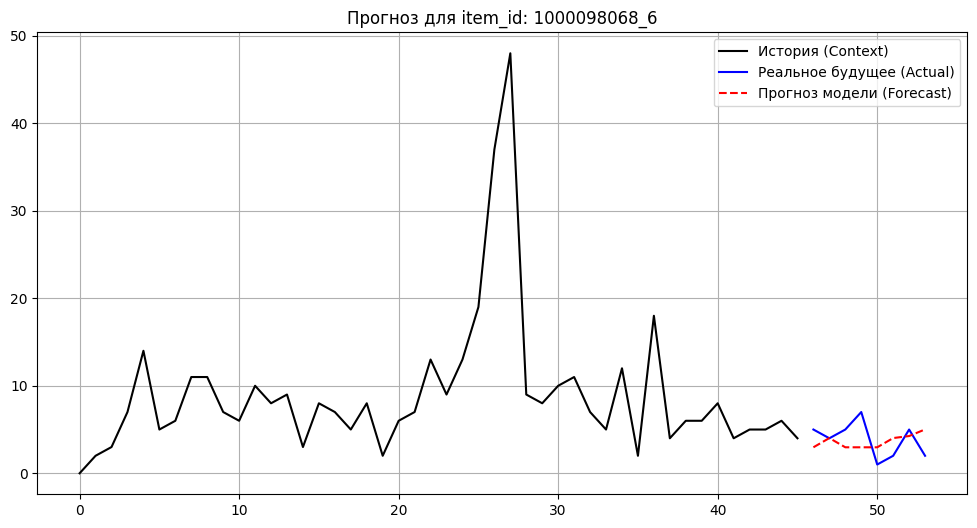

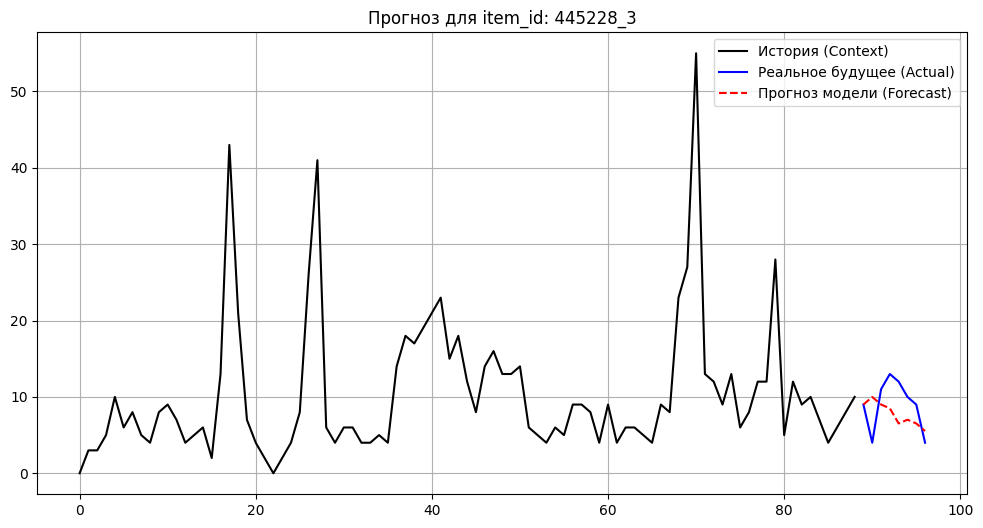

In [5]:
NUM_SAMPLES_TO_VISUALIZE = 20


print("\n--- Шаг 5: Визуализация случайных примеров ---")
if not test_subset:
    print("Нет данных для визуализации.")
else:
    for i in range(min(NUM_SAMPLES_TO_VISUALIZE, len(test_subset))):
        series = test_subset[i]
        item_id = series["item_id"]
        
        context_data = torch.tensor(series["target"])
        
        forecast_samples = pipeline.predict(
            context=context_data, prediction_length=PREDICTION_LENGTH, num_samples=20
        )
        median_forecast = torch.quantile(forecast_samples, 0.5, dim=1).squeeze().cpu().numpy()
        
        full_actual_series = actuals_map[item_id]
        
        plt.figure(figsize=(12, 6))
        
        # История
        plt.plot(
            range(len(full_actual_series) - PREDICTION_LENGTH), 
            full_actual_series[:-PREDICTION_LENGTH], 
            color='black', 
            label='История (Context)'
        )
        
        # Реальное будущее
        plt.plot(
            range(len(full_actual_series) - PREDICTION_LENGTH, len(full_actual_series)), 
            full_actual_series[-PREDICTION_LENGTH:], 
            color='blue', 
            label='Реальное будущее (Actual)'
        )
        
        # Прогноз модели (исправлено)
        plt.plot(
            range(len(full_actual_series) - PREDICTION_LENGTH, len(full_actual_series)), 
            median_forecast, # <-- ИСПОЛЬЗУЕМ МЕДИАННЫЙ ПРОГНОЗ
            color='red', 
            linestyle='--', 
            label='Прогноз модели (Forecast)'
        )
        
        plt.title(f"Прогноз для item_id: {item_id}")
        plt.legend()
        plt.grid(True)
        plt.show()